<a href="https://colab.research.google.com/github/maxHartman/HateTweets/blob/master/src/CIS519_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing & Load Functions

## Import Statements

In [0]:
from collections import defaultdict
import matplotlib.pylab as plt
import math
from gensim.models import Word2Vec
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
import string
import torch
import torch.nn.functional as F
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

### Hosted Runtime Configuration

In [0]:
from google.colab import drive
drive.mount('/content/drive')
fp = 'drive/Shared drives/CIS 519 Project/code/datasets/'

### Local Runtime Configuration:

In [0]:
fp = '~/Desktop/datasets/'

## Data Loading Functions

In [0]:
"""
NAME OPTIONS:
"acl_web"
"crowd_flower"
"data_world"
"harassment"
"olid"
"social_commentary"
"""

datasets = set([
                "acl_web",
                "crowd_flower", 
                "data_world", 
                "harassment",
                "olid",                
                "social_com"])

file_name = '/original_data'

def load_dataset(data_name, file_name=file_name, file_type='.tsv'):
    delimiter_map = {'.csv' : ',',
                     '.tsv' : '\t',
                    }
    data_path = fp + data_name + file_name + file_type

    if data_name not in datasets:
       raise ValueError('Argument is not name of an available dataset.')
       return None

    elif data_name == 'acl_web':
        return NotImplementedError('%s dataset has not been implemented to load yet' % data_name)
    
    elif data_name == 'crowd_flower':
        use_cols = [0, 1, 2]
        col_headers = ["raw_tweet", "code", "code_count"] 
        header_val = None
        idx_col = None

    elif data_name == 'data_world':
        use_cols = [0, 1, 2, 5, 6]
        col_headers = ["index", "coded_count", "hate_speech_count", "class", "raw_tweet"]
        header_val = 0
        idx_col = 0

    elif data_name == 'harassment':
        use_cols = [0, 1, 2]
        col_headers = ["index", "code", "raw_tweet"]
        header_val = 0
        idx_col = 0

    elif data_name == 'olid':
        use_cols = [0, 1, 2, 3, 4]
        col_headers = ["index", "raw_tweet", "subtask_a", "subtask_b", "subtask_c"]
        header_val = 0
        idx_col = 0

    elif data_name == 'social_com':
        return NotImplementedError('%s dataset has not been implemented to load yet' % data_name)
    
    df = pd.read_csv(data_path, delimiter=delimiter_map[file_type], index_col=idx_col, 
                     header=header_val, usecols=use_cols, names=col_headers, encoding='latin-1')
    df.reset_index(inplace=True, drop=True)

    return df

## Data Parsing Functions

In [0]:
def parse_acl_web(df):
    return NotImplementedError('dataset has not been implemented to parse yet')

In [0]:
def parse_crowd_flower(df):
    df['is_hate_speech'] = df['code'].apply({'spam': 0, 
                                             'hateful': 1,
                                             'abusive': 1,
                                             'normal': 0}
                                            .get)
    return df

In [0]:
def parse_data_world(df):
    """
    class = class label for majority of CF users.
          0 - hate speech,
          1 - offensive language,
          2 - neither
    """

    df['is_hate_speech'] = df['class'].apply({1: 0,
                                              0: 1, 
                                              2: 0}
                                             .get)
    return df

In [0]:
def parse_harassment(df):
    df['is_hate_speech'] = df['code'].apply({'H': 1, 
                                             'N': 0}
                                            .get)
    return df

In [0]:
def parse_olid(df):
    df['subtask_a'] = df['subtask_a'].apply({'OFF': 1, 
                                             'NOT': 0}
                                            .get)
    df['subtask_b'] = df['subtask_b'].apply({'TIN': 1, 
                                             'UNT': 0}
                                            .get)
    df['subtask_c'] = df['subtask_c'].apply({'IND': 1, 
                                             'GRP': 1, 
                                             'OTH': 0}
                                            .get)
    df['is_hate_speech'] = df[['subtask_a', 'subtask_b', 'subtask_c']].sum(axis=1)
    df['is_hate_speech'] = df['is_hate_speech'].apply({3: 1, 
                                                       2: 0, 
                                                       1: 0, 
                                                       0: 0}
                                                      .get)
    return df

In [0]:
def parse_social_com(df):
    return NotImplementedError('dataset has not been implemented to parse yet')

## Data Cleaning Functions

In [0]:
def clean_dataframe(df):
    replace_with_empty = '@\S+|&#|RT(\s*)|http(s*)://\S+|[^A-Za-z ]+'
    replace_with_space = '\s...\s'

    # removes tweeting at someone
    df['cleaned_tweet'] = df['raw_tweet'].replace(regex=True, to_replace=r'@\S+', value=r'')
     # turns elipses into just a space
    df['cleaned_tweet'].replace(regex=True, inplace=True, to_replace=r'\s...\s', value=r' ')
    # for some reason &'s show up before hashtags, so remove those specific &s
    df['cleaned_tweet'].replace(regex=True, inplace=True, to_replace=r'&#', value=r'')
    # remove the RT that comes before the retweet
    df['cleaned_tweet'].replace(regex=True, inplace=True, to_replace=r'RT(\s*)', value=r'')
    # remove any links to websites
    df['cleaned_tweet'].replace(regex=True, inplace=True, to_replace=r'http(s*)://\S+', value=r'')
    # remove any non letter or space
    df['cleaned_tweet'].replace(regex=True, inplace=True, to_replace=r'[^A-Za-z ]+',value=r'')
    # put it all to lower case
    df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()
    return  df

## Train & Test Set Generation Functions

In [0]:
def make_train_test(df, train_pct):
    df = df.sample(frac=1).reset_index(drop=True)
    train_cutoff = math.floor(train_pct * len(df))
    train, test = df[:train_cutoff], df[train_cutoff:]
    return train, test

# Data Loading

## Load Raw Data

In [0]:
df_crowd_flower = load_dataset('crowd_flower')
df_data_world = load_dataset('data_world')
df_harassment = load_dataset('harassment')
df_olid = load_dataset('olid')

## Clean & Parse Raw Data

In [0]:
desired_cols = ["is_hate_speech", "cleaned_tweet"]

In [0]:
df_crowd_flower_cleaned = clean_dataframe(parse_crowd_flower(df_crowd_flower))[desired_cols]
df_data_world_cleaned = clean_dataframe(parse_data_world(df_data_world))[desired_cols]
df_harassment_cleaned = clean_dataframe(parse_harassment(df_harassment))[desired_cols]
df_olid_cleaned = clean_dataframe(parse_olid(df_olid))[desired_cols]

In [0]:
df_crowd_flower_cleaned.sample(5)
df_data_world_cleaned.sample(5)
df_harassment_cleaned.sample(5)
df_olid_cleaned.sample(5)

## Make Train and Test Sets

In [0]:
TRAIN_PERCENTAGE = 0.80

In [0]:
cf_train, cf_test = make_train_test(df_crowd_flower_cleaned, TRAIN_PERCENTAGE)
dw_train, dw_test = make_train_test(df_data_world_cleaned, TRAIN_PERCENTAGE)
harass_train, harass_test = make_train_test(df_harassment_cleaned, TRAIN_PERCENTAGE)
olid_train, olid_test = make_train_test(df_olid_cleaned, TRAIN_PERCENTAGE)

# Experiments

## Helper Methods

In [0]:
def tokenize(text):
    text = " ".join(text.split())
    buffer = ""
    tokens = []
    for c in text:
        if c != ' ' and c not in string.punctuation:
            buffer+=c
        elif c != ' ' and c in string.punctuation:
            if len(buffer) != 0: tokens.append(buffer)
            tokens.append(c)
            buffer = ""
        else:
            if len(buffer) != 0: tokens.append(buffer)
            buffer = ""
    if len(buffer) != 0: tokens.append(buffer)
    return tokens

In [0]:
def construct_examples_from_df(dframe, row_name, label_name):
    D = []
    y = []
    for idx, row in dframe.iterrows():
        d = row[row_name] 
        label = row[label_name]
        tokens = tokenize(d)
        D.append(tokens)
        y.append(label)
    return D, y

## Doc2Vec Experimentation

### Doc2Vec Vector Computation

In [0]:
# Input: Our tokenized document list, tag prefix for labeling (either "TRAIN" or "TEST")
# Returns tagged list of documents for Doc2Vec model to use
def tag_docs(D, tag_prefix):
    tagged = []
    for idx, tweet in enumerate(D):
        tag = tag_prefix + '_' + str(idx)
        tagged.append(TaggedDocument(tweet, [tag]))
    return tagged

In [0]:
# Input: Doc2Vec model, data set (should use validation data here probably)
# Does not return anything, just trains the model and tunes params
def train_doc2vec(model, tagged_docs):
    for epoch in range(30):
        model.train(utils.shuffle([x for x in tagged_docs]), total_examples=len(tagged_docs), 
                    epochs=1)
        model.alpha -= 0.002
        model.min_alpha = model.alpha

In [0]:
# Input: Doc2Vec model, length of example vectors, tag of either "TRAIN" or "TEST"
# Returns a np matrix of document vectors, to input into Logistic Regression classifier
def get_vectors(model, vector_length, tag_type):
    vectors = np.zeros((model.corpus_count, vector_length))
    for i in range(model.corpus_count):
        prefix = tag_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors


### Doc2Vec Neural Nets

In [0]:
# FF NETWORK MODEL  
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(100, 100)
        self.l2 = torch.nn.Linear(100, 25)
        self.l3 = torch.nn.Linear(25, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        out1 = self.l1(x)
        out2 = self.l2(out1)
        out3 = self.l3(F.relu(out2))
        y_pred = self.sigmoid(out3)
        return y_pred

# CNN MODEL
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 100, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(100, 8, kernel_size=3)
        self.l1 = torch.nn.Linear(288, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        # reshape
        batch_size = out2.size(0)
        out2 = out2.view(batch_size, -1)
        y_pred = self.sigmoid(self.l1(out2))
        return y_pred

### Train Neural Net

In [0]:
def train_model(model, criterion, optimizer, num_epochs, X, y):
    # initialize weights and bias
    for m in model.modules():
        if isinstance(m,torch.nn.Linear):
            torch.nn.init.normal(m.weight, mean=0, std=0.1)
            torch.nn.init.constant(m.bias,0.1)
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.normal(m.weight, mean=0, std=0.1)
    
    best_acc = -1
    f1 = -1
    # train model
    for epoch in range(num_epochs):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc,_ = compute_NN_accuracy(y_pred, y)
        if acc > best_acc:
            best_acc = acc
            f1 = calculate_NN_f1(y_pred, y)
    
    # training accuracy after last epoch
    return best_acc, f1

### Run Doc2Vec Experiment

In [0]:
# INITIALIZE DOC2VEC, CREATE VECTORS

# GET TOKENIZED DATA, TAG DATA
D_train,y_train = construct_examples_from_df(harass_train, "cleaned_tweet", "is_hate_speech")
tagged_docs = tag_docs(D_train, "TRAIN")

# INITIALIZE DOC2VEC MODEL
doc_model = Doc2Vec(dm=0, vector_size=100, window=7, negative=5, min_count=2, alpha=0.1)
doc_model.build_vocab([x for x in tqdm(tagged_docs)])


In [0]:
# TRAINING

# TRAIN MODEL, VECTORIZE DATA
doc_model.train(utils.shuffle([x for x in tagged_docs]), total_examples=len(tagged_docs), 
                epochs=15)
X_train_vectors = get_vectors(doc_model, 100, "TRAIN")
X_train_vectors = X_train_vectors.reshape([len(D_train), 1, 10, 10])
X_train_tensor = torch.from_numpy(X_train_vectors)
X_train_tensor = X_train_tensor.float()
y_train_tensor = torch.FloatTensor(y_train)
y_train_tensor = y_train_tensor.view(y_train_tensor.size(0), -1)

# LOGISITIC REGRESSION CLASSIFIER
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train_vectors, y_train)
logreg = logreg.fit(X_train_vectors, y_train)
y_pred = logreg.predict(X_train_vectors)

# EVAULATE F1 SCORE, ACCURACY, CONFUSION MATRIX (FOR LOGISTIC REGRESSION)
f1 = calculate_f1(y_train, y_pred)
acc = compute_accuracy(y_pred, y_train)
plot_confusion_matrix(y_train, y_pred, title="Training Data 1", cmap=newcmp)
print(f1)
print(acc)

# CONVOLUTIONAL NEURAL NET CLASSIFIER
NN_model = Net()
LCE_criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(NN_model.parameters(), lr=0.01)
num_epochs = 100
NN_acc,NN_f1 = train_model(NN_model, LCE_criterion, optimizer, num_epochs, X_train_tensor, 
                           y_train_tensor)

print(NN_acc)
print(NN_f1)

In [0]:
# TESTING

# GET TOKENIZED DATA, TAG DATA
D_test,y_test = construct_examples_from_df(harass_test, "cleaned_tweet", "is_hate_speech")
tagged_docs_test = tag_docs(D_test,"TEST")

# INITIALIZE DOC2VEC MODEL
doc_test_model = Doc2Vec(dm=0, vector_size=100, window=7, negative=5, min_count=2, alpha=0.1)
doc_test_model.build_vocab([x for x in tqdm(tagged_docs_test)])
doc_test_model.train(utils.shuffle([x for x in tagged_docs_test]), 
                     total_examples=len(tagged_docs_test), epochs=15)

# LOGISTIC REGRESSION
X_test_vectors = get_vectors(doc_test_model, 100, "TEST")
y_pred_test = logreg.predict(X_test_vectors)
f1 = calculate_f1(y_test, y_pred_test)
acc = compute_accuracy(y_pred_test, y_test)
plot_confusion_matrix(y_test, y_pred_test, title="Training Data 1", cmap=newcmp)

print(f1)
print(acc)

# NEURAL NET
X_train_vectors = X_train_vectors.reshape([len(D_test), 1, 10, 10])
X_test_tensor = torch.from_numpy(X_test_vectors)
X_test_tensor = X_test_tensor.float()
y_test_tensor = torch.FloatTensor(y_test)
y_test_tensor = y_test_tensor.view(y_test_tensor.size(0),-1)
test_output = NN_model(X_test_tensor)
acc_test,predictions = compute_NN_accuracy(test_output, y_test_tensor)
f1_test = calculate_NN_f1(test_output, y_test_tensor)
plot_confusion_matrix(y_test, predictions, "DataWorld Test", cmap=newcmp)

print(acc_test)
print(f1_test)


## TFIDF Experimentation

### TFIDF Feature Computation

In [0]:
def get_vocabulary(D):
    vocab = set()
    vocab.add("<unk>")
    seen = set() 
    for doc in D:
        for t in doc:
            if t in seen:
                vocab.add(t)
            else:
                # add to seen set when we see it first time, when we encounter again 
                # we add to vocab
                seen.add(t)
    return vocab

In [0]:
def compute_idf(D, vocab):
    unk = "<unk>"
    numerator = len(D)
    idf = {v:0 for v in vocab}
    for doc in D:
        doc = set(doc)
        unk_used = False
        for t in doc:
            if t in vocab:
                idf[t] += 1
            elif not(unk_used):
                idf[unk] += 1
                unk_used = True
    for feat in idf.keys():
        idf[feat] = math.log(numerator/idf[feat])
    return idf

In [0]:
class TFIDFFeaturizer(object):
    def __init__(self, idf):
        self.idf = idf
    
    def convert_document_to_feature_dictionary(self, doc, vocab):
        unk = "<unk>"
        doc_dict = {token:0 for token in vocab}
        for t in doc:
            if t in vocab:
                doc_dict[t] = doc_dict.get(t, 0) + 1
            else:
                doc_dict[unk] = doc_dict.get(unk, 0) + 1
        
        for token in doc_dict.keys():
            doc_dict[token] *= self.idf[token]
        
        return doc_dict

In [0]:
def convert_to_features(D, featurizer, vocab): 
    X = []
    for doc in D: 
        X.append(featurizer.convert_document_to_feature_dictionary(doc, vocab))
    return X

### Run TFIDF-Features Experiment

In [0]:
# TRAIN

# GET TOKENIZED DATA AND VOCAB
D_train,y_train = construct_examples_from_df(olid_train, "cleaned_tweet", "is_hate_speech")
vocab = get_vocabulary(D_train)

# GET TFIDF-FEATURIZED EXAMPLES
tfidf = TFIDFFeaturizer(compute_idf(D_train, vocab))
X_train = convert_to_features(D_train, tfidf, vocab)

# SVM CLASSIFIER
vectorizer = DictVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
svm = LinearSVC(loss='hinge', max_iter=10000)
svm.fit(X_train_vect, y_train)


0.10005726229163753
0.38297013720742534


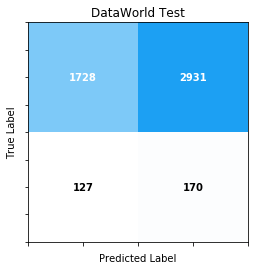

In [0]:
# TEST

D_test,y_test = construct_examples_from_df(dw_test, "cleaned_tweet", "is_hate_speech")
X_test = convert_to_features(D_test, tfidf, vocab)
y_pred_test = svm.predict(vectorizer.fit_transform(X_test))

# EVAULATE F1 SCORE, ACCURACY, CONFUSION MATRIX OF TESTING DATA
f1_test = calculate_f1(y_test, y_pred_test)
acc_test = compute_accuracy(y_pred_test, y_test)
plot_confusion_matrix(y_test, y_pred_test, title="DataWorld Test", cmap=newcmp)
print(f1_test)
print(acc_test)


## Evaluation Methods

### TFIDF

In [0]:
def calculate_f1(y_gold, y_model):
    num_pred_positive = 1e-5
    num_positive = 1e-5
    for label in y_model:
        if label == 1:
            # count total predicted num of positives
            num_pred_positive += 1
    for label in y_gold:
        if label == 1:
            # count total actual num of positives
            num_positive += 1
    # total true predicted positives
    num_true = sum(int((y1 == 1 and y2 == 1)) for y1,y2 in list(zip(y_gold,y_model)))
    precision = num_true / num_pred_positive
    recall = num_true / num_positive
    F1 = 2*(precision*recall)/(precision+recall+1e-5)
    return F1

In [0]:
def compute_accuracy(y_pred, y_gold):
    num_correct = 0
    num_examples = len(y_gold)
    for i in range(num_examples):
        if y_pred[i] == y_gold[i]:
            num_correct += 1
    return num_correct/num_examples

### Doc2Vec NN

In [0]:
def compute_NN_accuracy(y_pred, y_true):
    num_correct = 0
    num_instances = y_true.size(0)
    predictions = []
    for i in range(num_instances):
        curr_pred = y_pred[i][0]
        curr_true = y_true[i][0]
        y_est = 1 if curr_pred > 0.5 else 0
        predictions.append(y_est)
        if y_est == curr_true:
            num_correct += 1
    return (num_correct / num_instances), predictions

In [0]:
def calculate_NN_f1(y_pred, y_true):
    num_pred_positive = 1e-5
    num_positive = 1e-5
    num_true = 1e-5
    num_instances = y_true.size(0)
    for i in range(num_instances):
        curr_pred = y_pred[i][0]
        curr_true = y_true[i][0]
        y_est = 1 if curr_pred > 0.5 else 0
        if y_est == 1:
            # count total predicted num of positives
            num_pred_positive += 1
        if curr_true == 1:
            num_positive += 1
        if curr_true == 1 and y_est == 1:
            # count total true predicted positives
            num_true += 1 
        
    precision = num_true / num_pred_positive
    recall = num_true / num_positive
    F1 = 2*(precision*recall)/(precision+recall+1e-5)
    return F1

## Results Visualization

In [0]:
# CREATE COLORMAP
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.113, 1, N)
vals[:, 1] = np.linspace(0.631, 1, N)
vals[:, 2] = np.linspace(0.953, 1, N)
newcmp = ListedColormap(vals[::-1])

In [0]:
# Inputs: true labels, predicted labels, matrix title, matrix colormap
# Returns the figure, shows the figure automatically when called
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set(title=title,ylabel='True Label',xlabel='Predicted Label')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontweight='bold',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

In [0]:
# Input: list of F1 scores, list of datasets corresponding to F1 scores, graph title
# Returns graph, must call plt.show() after run to show the graph

def plot_scores(f1_scores, data_titles, title):
    TEAL = (0.113, 0.631, 0.953, 1.0)
    # how many different datasets are we comparing?
    idx = np.arange(len(data_titles))
    plt.ylim((0.2,0.5))
    # plot bar for each test and its F1 score
    plt.bar(idx,f1_scores,width=0.4,color=TEAL)
    plt.xlabel('Training Set')
    plt.ylabel('F1 Score')
    plt.title(title)
    plt.xticks(idx, data_titles, fontsize=5, rotation=45)
    for i,v in enumerate(f1_scores):
        plt.text(i, v+0.01, str(v), color=TEAL, ha='center', fontweight='bold')
    return plt

In [0]:
data = ["DataWorld", "OLID", "Golbeck", "Founta"]
title = "Average Test Accuracy vs. Training Data"
avg_acc_scores = [0.625, 0.667, 0.655, 0.640]
#plot_scores(avg_acc_scores,data,title)
avg_f1_score = [0.246, 0.464, 0.243, 0.271]
title2 = "Average F1 Score vs. Training Data"
plot_scores(avg_f1_score, data, title2)